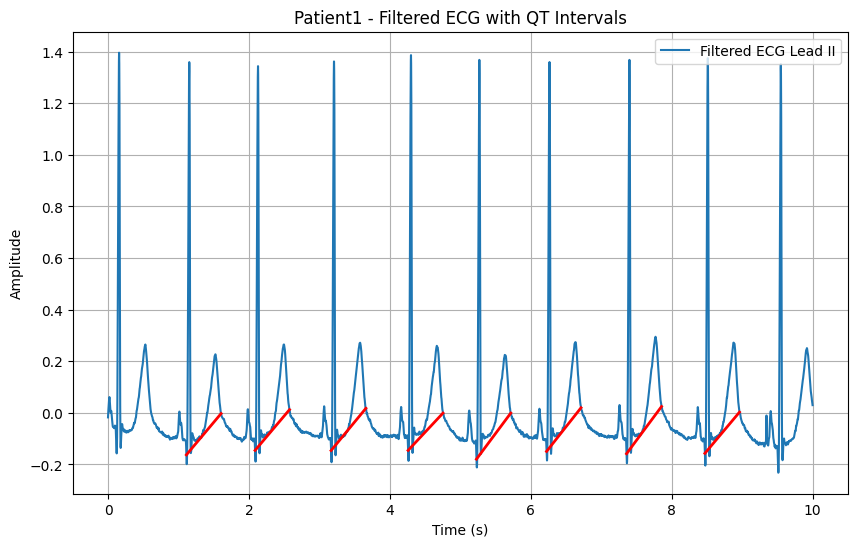

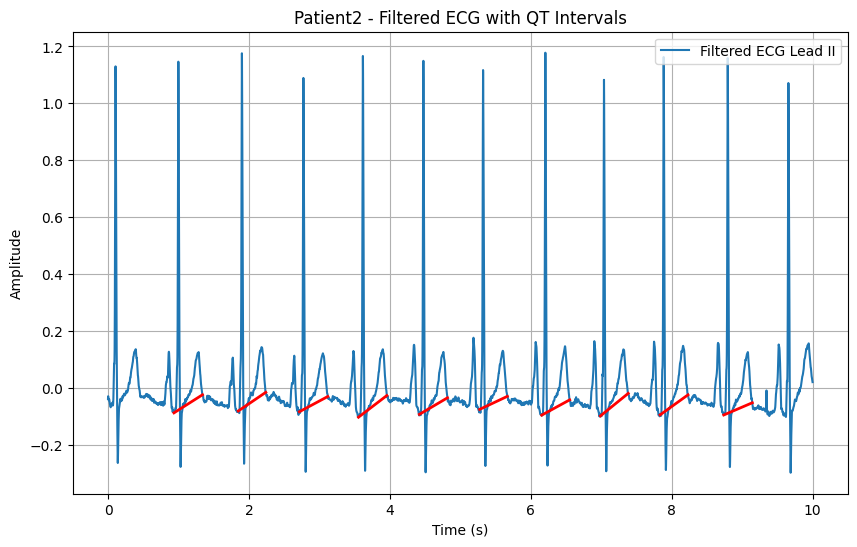

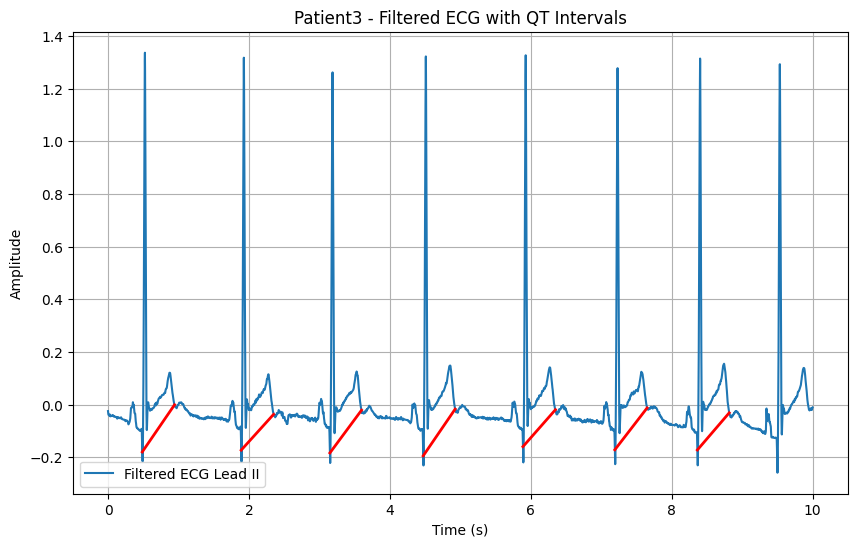

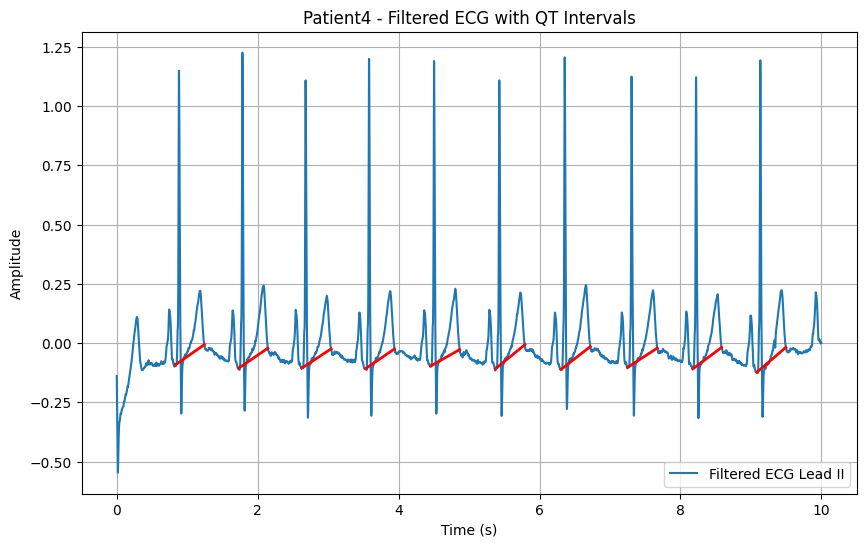

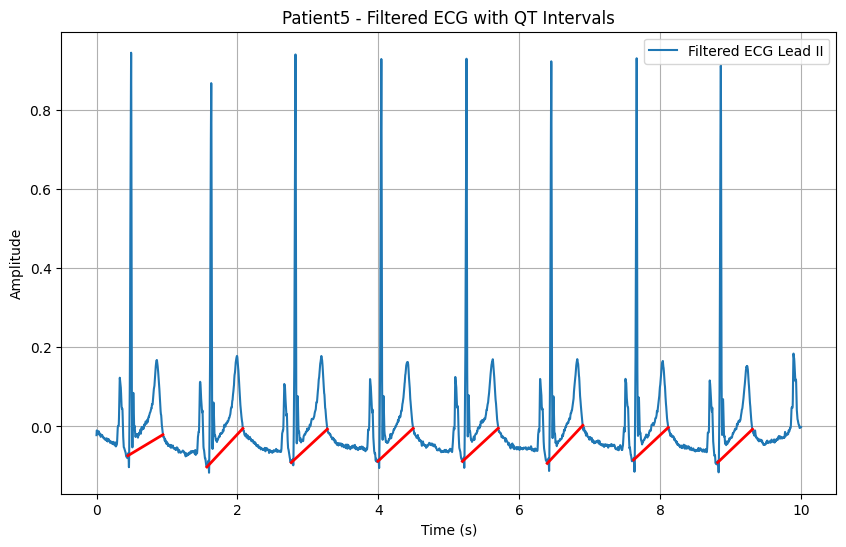

Standard Deviation for AB: 0.18
Standard Deviation for BB: 0.00
Standard Deviation for AA: 0.23
Mean QT Interval for AB: 0.49 seconds
Mean QT Interval for BB: 0.43 seconds
Mean QT Interval for AA: 0.50 seconds

ANOVA results for Group 1:
ANOVA results: F-statistic = 0.0585893891213965, p-value = 0.9431198174674053
No statistically significant difference between the groups (fail to reject H0).
T-test AB vs BB: t-stat = 0.30392293322448627, p-value = 0.7638059924108722
T-test AB vs AA: t-stat = -0.19608048407348472, p-value = 0.8448655831446004
T-test BB vs AA: t-stat = -0.27705891260356413, p-value = 0.7823011167350746
Standard Deviation for AB: 0.18
Standard Deviation for BB: 0.00
Standard Deviation for AA: 0.23
Mean QT Interval for AB: 0.49 seconds
Mean QT Interval for BB: 0.43 seconds
Mean QT Interval for AA: 0.50 seconds

ANOVA results for Group 2:
ANOVA results: F-statistic = 0.0585893891213965, p-value = 0.9431198174674053
No statistically significant difference between the groups

In [49]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import glob
import os
import neurokit2 as nk
from scipy.signal import butter, filtfilt
from scipy.stats import f_oneway, ttest_ind

# Load ECG Data
def loadEcg(path):
    dat_files = glob.glob(os.path.join(path, "*.dat"))
    hea_files = glob.glob(os.path.join(path, "*.hea"))
    base_names = set([os.path.splitext(os.path.basename(f))[0] for f in dat_files + hea_files])

    ecg_dict, field_dict, fs_dict = {}, {}, {}

    for i, base_name in enumerate(sorted(base_names), start=1):
        ecg, fields = wfdb.rdsamp(os.path.join(path, base_name))
        patient_key = f'Patient{i}'
        ecg_dict[patient_key] = ecg
        field_dict[patient_key] = fields
        fs_dict[patient_key] = fields['fs']
    return ecg_dict, field_dict, fs_dict

# Filter ECG signal (Lead II)
def filterEcg(signal, fs, lowcut=0.5, highcut=100, order=2):
    nyquist = 0.5 * fs 
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    
    # Apply the filter bidirectionally using filtfilt for zero phase distortion
    filtered_signal = filtfilt(b, a, signal[:, 1])
    
    return filtered_signal

# Calculate QT intervals
def calculateQtIntervals(key, filtered_signal, fs, plot_count, max_plots=5):
    ecg_analysis, _ = nk.ecg_process(filtered_signal, sampling_rate=fs)
    q_points = ecg_analysis['ECG_Q_Peaks']
    t_points = ecg_analysis['ECG_T_Offsets']
    q_indices = q_points[q_points == 1].index.to_list()
    t_indices = t_points[t_points == 1].index.to_list()

    time = np.arange(filtered_signal.size) / fs

    qt_intervals = []
    
    # Plot filtered signal with QT intervals marked, but only for the first 'max_plots' patients
    if plot_count < max_plots:
        plt.figure(figsize=(10, 6))
        plt.plot(time, filtered_signal, label='Filtered ECG Lead II')
        
        for q, t in zip(q_indices, t_indices):
            if t > q:
                qt_interval = (t - q) / fs
                qt_intervals.append(qt_interval)
                plt.plot([q / fs, t / fs], [filtered_signal[q], filtered_signal[t]], color='red', lw=2)

        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title(f'{key} - Filtered ECG with QT Intervals')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Calculate QT intervals without plotting for others
    else:
        for q, t in zip(q_indices, t_indices):
            if t > q:
                qt_interval = (t - q) / fs
                qt_intervals.append(qt_interval)

    return qt_intervals

# Calculate and store average QT intervals
def calculateAverageQt(ecg_dict, fs_dict, max_plots=5):
    average_qt_dict = {}
    plot_count = 0  # Track number of patients plotted
    for key, ecg_signal in ecg_dict.items():
        fs = fs_dict[key]
        filtered_signal = filterEcg(ecg_signal, fs)
        qt_intervals = calculateQtIntervals(key, filtered_signal, fs, plot_count, max_plots)
        average_qt_interval = np.mean(qt_intervals) if qt_intervals else None
        average_qt_dict[key] = average_qt_interval
        plot_count += 1  # Increment after plotting
    return average_qt_dict

# Set the path to your data folder
path = 'D:/Masters/bioinformatics/project/QTproject/new'

# # Load the ECG data
# ecg_dict, field_dict, fs_dict = loadEcg(path)

# # Calculate average QT intervals for all patients (with plots for only 5 patients)
# average_qt_intervals = calculateAverageQt(ecg_dict, fs_dict, max_plots=1)

# Display average QT intervals for all patients
    
# TASK 3: Function to load genotype data and reshape (reshaping to keep the structure for 7 rows). New genotype starts
# every 7th row (if you look at the result txt file, you can see this).

def loadAndReshapeGenotype(filepath):
   results = pd.read_csv(filepath, delimiter="\t", header=None)
   selected = results.iloc[:, 1::7]  # Select every 7th column starting from index 1 --> each new genotype AA, AB or BB.
   s_array = selected.values
   reshaped = s_array.reshape(7, -1)
   return reshaped


# TASK 3: Function to extract QT intervals based on genotype AA, AB or BB. Thus, this function goes through the reshaped
# data, consisting of 7 rows and 129 columns. 129 is the number of different genotypes i.e. different patients.
# One group to study = same genotype from one row. E.g. all BB genotypes from row 1. YOU NEED THIS INFORMATION ABOUT
# ALL 7 ROWS / GROUPS.

def QtByGenotype(reshaped, average_qt_dict, group_index):
    patients = list(average_qt_dict.keys())
    AB1 = np.where(reshaped[0, :] == "AB")[0]
    BB1 = np.where(reshaped[0, :] == "BB")[0]
    AA1 = np.where(reshaped[0, :] == "AA")[0]
    AB2 = np.where(reshaped[1, :] == "AB")[0]
    BB2 = np.where(reshaped[1, :] == "BB")[0]
    AA2 = np.where(reshaped[1, :] == "AA")[0]
    AB3 = np.where(reshaped[2, :] == "AB")[0] # This is the third row (remember, that python indexing starts at 0)
    BB3 = np.where(reshaped[2, :] == "BB")[0]
    AA3 = np.where(reshaped[2, :] == "AA")[0] 
    
    qt_AB1 = [average_qt_dict[patients[idx]] for idx in AB1 if average_qt_dict[patients[idx]] is not None]
    qt_BB1 = [average_qt_dict[patients[idx]] for idx in BB1 if average_qt_dict[patients[idx]] is not None]
    qt_AA1 = [average_qt_dict[patients[idx]] for idx in AA1 if average_qt_dict[patients[idx]] is not None]
    qt_AB2 = [average_qt_dict[patients[idx]] for idx in AB2 if average_qt_dict[patients[idx]] is not None]
    qt_BB2 = [average_qt_dict[patients[idx]] for idx in BB2 if average_qt_dict[patients[idx]] is not None]
    qt_AA2 = [average_qt_dict[patients[idx]] for idx in AA2 if average_qt_dict[patients[idx]] is not None]
    qt_AB3 = [average_qt_dict[patients[idx]] for idx in AB3 if average_qt_dict[patients[idx]] is not None]
    qt_BB3 = [average_qt_dict[patients[idx]] for idx in BB3 if average_qt_dict[patients[idx]] is not None]
    qt_AA3 = [average_qt_dict[patients[idx]] for idx in AA3 if average_qt_dict[patients[idx]] is not None]
    
    mean_AB1 = np.mean(qt_AB1)
    mean_BB1 = np.mean(qt_BB1)
    mean_AA1 = np.mean(qt_AA1)
    mean_AB2 = np.mean(qt_AB2)
    mean_BB2 = np.mean(qt_BB2)
    mean_AA2 = np.mean(qt_AA2)
    mean_AB3 = np.mean(qt_AB3)
    mean_BB3 = np.mean(qt_BB3)
    mean_AA3 = np.mean(qt_AA3)

    print(f"Mean QT Interval for AB: {mean_AB3:.2f} seconds")
    print(f"Mean QT Interval for BB: {mean_BB3:.2f} seconds")
    print(f"Mean QT Interval for AA: {mean_AA3:.2f} seconds")
    
    
    return  qt_AB1, qt_BB1, qt_AA1, qt_AB2, qt_BB2, qt_AA2, qt_AB3, qt_BB3, qt_AA3


def visualize_genotype_barplot(reshaped):
    genotype_counts = {}
    
    for i in range(reshaped.shape[0]):  # Loop through each group (row)
        unique, counts = np.unique(reshaped[i, :], return_counts=True)
        genotype_counts[f'Group {i+1}'] = dict(zip(unique, counts))

    # Convert to DataFrame for easy plotting
    genotype_counts_df = pd.DataFrame(genotype_counts).fillna(0).T  # Transpose for better format
    genotype_counts_df = genotype_counts_df.astype(int)  # Ensure counts are integers
    
    # Create a bar plot
    genotype_counts_df.plot(kind='bar', stacked=True, figsize=(10, 6))
    
    plt.title("Genotype Frequencies Across Groups")
    plt.xlabel("Groups")
    plt.ylabel("Counts")
    plt.xticks(rotation=0)
    plt.legend(title="Genotype")
    plt.show()

# Usage
# Call this function with the reshaped data
# TASK 3: Function to perform ANOVA and print results. THIS FUNCTION IS COMMENTED OUT, SO YOU CAN FIRST DOWNLOAD YOU DATA.

def anovaTest(qt_AB3, qt_BB3, qt_AA3):
    stat, p_value = f_oneway(qt_AB3, qt_BB3, qt_AA3)
    print(f"ANOVA results: F-statistic = {stat}, p-value = {p_value}")
    if p_value < 0.05:
        print("Statistically significant difference between the groups (reject H0).")
    else:
        print("No statistically significant difference between the groups (fail to reject H0).")

    # Optionally perform t-tests between pairs of groups if ANOVA is significant
    t_AB_BB, p_AB_BB = ttest_ind(qt_AB3, qt_BB3)
    t_AB_AA, p_AB_AA = ttest_ind(qt_AB3, qt_AA3)
    t_BB_AA, p_BB_AA = ttest_ind(qt_BB3, qt_AA3)

    print(f"T-test AB vs BB: t-stat = {t_AB_BB}, p-value = {p_AB_BB}")
    print(f"T-test AB vs AA: t-stat = {t_AB_AA}, p-value = {p_AB_AA}")
    print(f"T-test BB vs AA: t-stat = {t_BB_AA}, p-value = {p_BB_AA}")


# Main processing function
def main():
    ecg_dict, field_dict, fs_dict = loadEcg(path)
    average_qt_dict = calculateAverageQt(ecg_dict, fs_dict)

    genotype_file = '/Masters/bioinformatics/project/extracted_genotypes.txt'
    reshaped_genotype = loadAndReshapeGenotype(genotype_file)

    # CALCULATE THE DIFFERENT GROUPS HERE, E.G. FOR GROUP 3 (ROW 3) QT_AB3, QT_BB3, QT_AA3. USE THE
    # QtByGenotype FUNCTION!

        # Loop through each group (7 rows in reshaped_genotype)
    for group_index in range(7):
        qt_AB, qt_BB, qt_AA = QtByGenotype(reshaped_genotype, average_qt_dict, group_index)
        
        # Perform ANOVA test for the current group
        print(f"\nANOVA results for Group {group_index + 1}:")
        anovaTest(qt_AB, qt_BB, qt_AA)

# Run the main function
if __name__ == "__main__":
    main()


In [79]:
 print(scipy.__version__)

1.13.1


In [20]:
def countNormalPatients(average_qt_dict):
    normal_range = (0.36, 0.46)  
    normal_patients = {key: qt for key, qt in average_qt_dict.items() if qt is not None and normal_range[0] <= qt <= normal_range[1]}
    return len(normal_patients), normal_patients

def countNoneValues(average_qt_dict):
    return sum(1 for qt in average_qt_dict.values() if qt is None)


normal_count, normal_patients = countNormalPatients(average_qt_intervals)
print(f"Number of patients with normal QT intervals (360 ms – 460 ms): {normal_count}")


Number of patients with normal QT intervals (360 ms – 460 ms): 84


In [21]:
print("\n--- INTERMEDIATE RESULTS ---")
# Sampling frequencies
sampling_frequencies = list(fs_dict.values())
unique_frequencies, counts = np.unique(sampling_frequencies, return_counts=True)
print(f"Common sampling frequencies (in Hz): {dict(zip(unique_frequencies, counts))}")

# Filter properties
print(f"Filter applied: FIR Filter, Order = 20, Cutoff = 50 Hz")


--- INTERMEDIATE RESULTS ---
Common sampling frequencies (in Hz): {1000: 129}
Filter applied: FIR Filter, Order = 20, Cutoff = 50 Hz


In [22]:
none_count = countNoneValues(average_qt_intervals)
print(f"Number of 'None' values in the average QT dictionary: {none_count}")

Number of 'None' values in the average QT dictionary: 1


In [26]:
import matplotlib.pyplot as plt

def plot_qt_interval_for_patient(ecg_dict, fs_dict, patient_id):
    """
    Plots the average QT interval for a specified patient.
    
    Parameters:
        ecg_dict (dict): Dictionary containing ECG signals for each patient.
        fs_dict (dict): Dictionary containing sampling frequencies for each patient.
        patient_id (int): The ID of the patient to plot.
    """
    # Check if the patient ID exists in the data
    if patient_id not in ecg_dict or patient_id not in fs_dict:
        print(f"Patient {patient_id} data is not available.")
        return

    # Load the ECG signal and sampling frequency for the specified patient
    filtered_signal = ecg_dict[patient_id]
    fs = fs_dict[patient_id]

    # Initialize the list for QT intervals
    qt_intervals = []
    
    # Assuming 'q_indices' and 't_indices' are calculated for this patient
    q_indices, t_indices = calculate_qt_indices(filtered_signal)  # Define or calculate these indices as per your analysis

    # Create a time array based on the length of the filtered signal and sampling frequency
    time = np.arange(len(filtered_signal)) / fs

    # Plot the filtered signal with QT intervals marked
    plt.figure(figsize=(10, 6))
    plt.plot(time, filtered_signal, label='Filtered ECG Lead II')

    for q, t in zip(q_indices, t_indices):
        if t > q:
            qt_interval = (t - q) / fs
            qt_intervals.append(qt_interval)
            plt.plot([q / fs, t / fs], [filtered_signal[q], filtered_signal[t]], color='red', lw=2)

    # Set plot labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Patient {patient_id} - Filtered ECG with QT Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the average QT interval for the patient
    average_qt_interval = np.mean(qt_intervals) if qt_intervals else None
    print(f'Average QT interval for Patient {patient_id}: {average_qt_interval} seconds')

In [27]:
patient_number = int(input("Enter the patient number to plot: "))

# Call the function to plot for the specified patient
plot_qt_interval_for_patient(ecg_dict, fs_dict, patient_number)

Enter the patient number to plot:  22


Patient 22 data is not available.
